In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#from ROHSApy import ROHSA


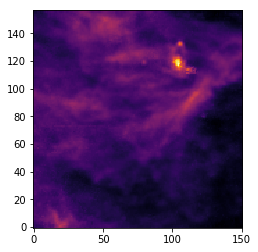

In [4]:
fitsname = "GHIGLS_UMA_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0]

#The data from the cube was plotted
plt.figure()
plt.imshow(np.sum(cube,0), origin="lower", cmap="inferno")
plt.show()


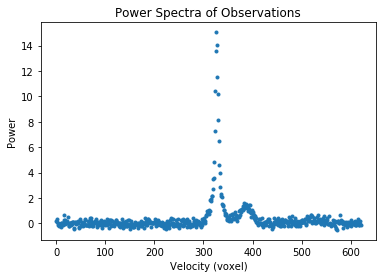

In [5]:
#the spectrum from a single pixel was plotted

# frame = hdu[0].data[0][400,:1,:1]
# dat = hdu[0].data

plt.plot(cube[:,0,0], linestyle = "none", marker = '.')
plt.title("Power Spectra of Observations")
plt.xlabel("Velocity (voxel)")
plt.ylabel("Power")
plt.show()

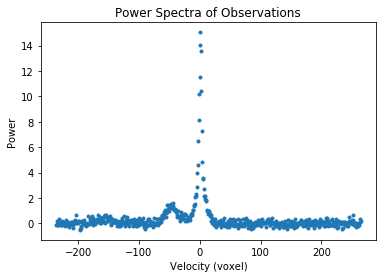

In [6]:
#the velocities were corrected by the information in the fits files, and were centered at zero

CRVAL = hdr['CRVAL3']
CDELT = hdr['CDELT3']
CRPIX = hdr['CRPIX3']

ind_array = np.arange(cube.shape[0])

v = (CRVAL + CDELT*((ind_array) - CRPIX))/1000

plt.plot(v, cube[:,0,0], linestyle = "none", marker = '.')
plt.title("Power Spectra of Observations")
plt.xlabel("Velocity (voxel)")
plt.ylabel("Power")
plt.show()


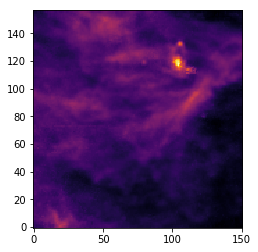

In [9]:
#The column density from equation 2

col_den = 1.823*(10**18)*np.sum(cube, 0)

plt.figure()
plt.imshow(col_den, origin="lower", cmap="inferno")
plt.show()





In [11]:
#centroid velocity from equation 4

# for i in np.shape(v):
#     i = 0
#     v_cent = np.sum(cube*v[i], 0)/np.sum(cube, 0)
#     i = i + 1


v_cent = (np.sum(cube*v, 0)/np.sum(cube, 0))
plt.figure()
plt.imshow(v_cent, origin="lower", cmap="coolwarm")
plt.show()


ValueError: operands could not be broadcast together with shapes (621,157,151) (621,) 

In [12]:
#velocity dispersion from equation 6

# for i in np.shape(v):
#     i = 0
#     v_cent = np.sum(cube*v[i]**2, 0)/np.sum(cube, 0)
#     i = i + 1


v_cent = (np.sum(cube*(v**2), 0)/np.sum(cube, 0))
plt.figure()
plt.imshow(v_cent, origin="lower", cmap="coolwarm")
plt.show()

ValueError: operands could not be broadcast together with shapes (621,157,151) (621,) 